In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load pollution data
train_df = pd.read_csv('air_pollution_dataset/train.csv')
test_df = pd.read_csv('air_pollution_dataset/test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("\nTraining data columns:")
print(train_df.columns.tolist())
print("\nTraining data info:")
print(train_df.info())
print("\nPollution value statistics:")
print(train_df['pollution_value'].describe())

Training samples: 7649
Test samples: 2739

Training data columns:
['id', 'latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month', 'pollution_value']

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7649 entries, 0 to 7648
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7649 non-null   int64  
 1   latitude         7636 non-null   float64
 2   longitude        7636 non-null   float64
 3   day_of_year      7649 non-null   int64  
 4   day_of_week      7649 non-null   int64  
 5   hour             7649 non-null   int64  
 6   month            7649 non-null   int64  
 7   pollution_value  7649 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 478.2 KB
None

Pollution value statistics:
count    7649.000000
mean       22.813227
std        46.650639
min         3.500000
25%         8.500000
50%        13.171778
75%        22.500000
max      1352.80

In [4]:
train_df.dropna(inplace=True)

In [5]:
from sklearn.cluster import KMeans

def create_enhanced_features(df, is_training=True):
    """Create comprehensive feature set from enhanced pollution model"""
    df_enhanced = df.copy()
    
    # Cyclical time features (improved encoding)
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['day_year_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_year_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_week_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_week_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    
    # Enhanced categorical time features
    df_enhanced['is_weekend'] = (df_enhanced['day_of_week'] >= 5).astype(int)
    df_enhanced['is_rush_hour_morning'] = df_enhanced['hour'].isin([7, 8, 9]).astype(int)
    df_enhanced['is_rush_hour_evening'] = df_enhanced['hour'].isin([17, 18, 19]).astype(int)
    df_enhanced['is_rush_hour'] = (df_enhanced['is_rush_hour_morning'] | df_enhanced['is_rush_hour_evening']).astype(int)
    df_enhanced['is_night'] = df_enhanced['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    df_enhanced['is_business_hours'] = df_enhanced['hour'].isin([9, 10, 11, 12, 13, 14, 15, 16]).astype(int)
    
    # Seasonal features
    df_enhanced['is_summer'] = df_enhanced['month'].isin([6, 7, 8]).astype(int)
    df_enhanced['is_winter'] = df_enhanced['month'].isin([12, 1, 2]).astype(int)
    df_enhanced['is_spring'] = df_enhanced['month'].isin([3, 4, 5]).astype(int)
    df_enhanced['is_fall'] = df_enhanced['month'].isin([9, 10, 11]).astype(int)
    
    # Enhanced geographic features
    df_enhanced['lat_lon_interaction'] = df_enhanced['latitude'] * df_enhanced['longitude']
    df_enhanced['lat_squared'] = df_enhanced['latitude'] ** 2
    df_enhanced['lon_squared'] = df_enhanced['longitude'] ** 2
    
    # Distance from geographic center
    centroid_lat = df_enhanced['latitude'].mean()
    centroid_lon = df_enhanced['longitude'].mean()
    df_enhanced['distance_from_center'] = np.sqrt(
        (df_enhanced['latitude'] - centroid_lat)**2 + 
        (df_enhanced['longitude'] - centroid_lon)**2
    )
    
    # Geographic clustering (more clusters for better granularity)
    coords = df_enhanced[['latitude', 'longitude']].values
    kmeans = KMeans(n_clusters=25, random_state=42, n_init=10)
    df_enhanced['location_cluster'] = kmeans.fit_predict(coords)
    
    # Density-based features
    df_enhanced['location_density'] = df_enhanced.groupby(['latitude', 'longitude'])['latitude'].transform('count')
    
    # Enhanced interaction features
    df_enhanced['hour_month_interaction'] = df_enhanced['hour'] * df_enhanced['month']
    df_enhanced['weekend_hour'] = df_enhanced['is_weekend'] * df_enhanced['hour']
    df_enhanced['season_hour'] = df_enhanced['is_summer'] * df_enhanced['hour']
    df_enhanced['cluster_hour'] = df_enhanced['location_cluster'] * df_enhanced['hour']
    df_enhanced['rush_hour_cluster'] = df_enhanced['is_rush_hour'] * df_enhanced['location_cluster']
    
    # Time-based polynomial features
    df_enhanced['hour_squared'] = df_enhanced['hour'] ** 2
    df_enhanced['hour_cubed'] = df_enhanced['hour'] ** 3
    df_enhanced['day_year_squared'] = df_enhanced['day_of_year'] ** 2
    
    # Location-based statistical features
    df_enhanced['lat_month_interaction'] = df_enhanced['latitude'] * df_enhanced['month']
    df_enhanced['lon_month_interaction'] = df_enhanced['longitude'] * df_enhanced['month']
    df_enhanced['distance_hour_interaction'] = df_enhanced['distance_from_center'] * df_enhanced['hour']
    
    # Additional cyclical features
    df_enhanced['hour_phase'] = (df_enhanced['hour'] % 12) / 12  # AM/PM phase
    df_enhanced['day_progress'] = df_enhanced['day_of_year'] / 365  # Year progress
    df_enhanced['week_progress'] = (df_enhanced['day_of_week'] % 7) / 7  # Week progress
    
    return df_enhanced

# Create enhanced features
train_features = create_enhanced_features(train_df, is_training=True)
test_features = create_enhanced_features(test_df, is_training=False)

# Define feature columns (all enhanced features)
base_features = ['latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month']
cyclical_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_year_sin', 'day_year_cos', 'day_week_sin', 'day_week_cos']
categorical_features = ['is_weekend', 'is_rush_hour_morning', 'is_rush_hour_evening', 'is_rush_hour', 'is_night', 'is_business_hours', 'is_summer', 'is_winter', 'is_spring', 'is_fall']
geographic_features = ['lat_lon_interaction', 'lat_squared', 'lon_squared', 'distance_from_center', 'location_cluster', 'location_density']
interaction_features = ['hour_month_interaction', 'weekend_hour', 'season_hour', 'cluster_hour', 'rush_hour_cluster']
polynomial_features = ['hour_squared', 'hour_cubed', 'day_year_squared']
additional_features = ['lat_month_interaction', 'lon_month_interaction', 'distance_hour_interaction', 'hour_phase', 'day_progress', 'week_progress']

all_features = base_features + cyclical_features + categorical_features + geographic_features + interaction_features + polynomial_features + additional_features

# Prepare training data
feature_cols = [col for col in train_features.columns if col != 'pollution_value' and col in all_features]
X = train_features[feature_cols]
y = train_features['pollution_value']

print(f"Enhanced features created: {len(feature_cols)}")
print(f"Feature categories:")
print(f"- Base features: {len(base_features)}")
print(f"- Cyclical features: {len(cyclical_features)}")
print(f"- Categorical features: {len(categorical_features)}")
print(f"- Geographic features: {len(geographic_features)}")
print(f"- Interaction features: {len(interaction_features)}")
print(f"- Polynomial features: {len(polynomial_features)}")
print(f"- Additional features: {len(additional_features)}")
print(f"Total feature columns: {feature_cols}")

  File "c:\Users\damod\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Enhanced features created: 44
Feature categories:
- Base features: 6
- Cyclical features: 8
- Categorical features: 10
- Geographic features: 6
- Interaction features: 5
- Polynomial features: 3
- Additional features: 6
Total feature columns: ['latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_year_sin', 'day_year_cos', 'day_week_sin', 'day_week_cos', 'is_weekend', 'is_rush_hour_morning', 'is_rush_hour_evening', 'is_rush_hour', 'is_night', 'is_business_hours', 'is_summer', 'is_winter', 'is_spring', 'is_fall', 'lat_lon_interaction', 'lat_squared', 'lon_squared', 'distance_from_center', 'location_cluster', 'location_density', 'hour_month_interaction', 'weekend_hour', 'season_hour', 'cluster_hour', 'rush_hour_cluster', 'hour_squared', 'hour_cubed', 'day_year_squared', 'lat_month_interaction', 'lon_month_interaction', 'distance_hour_interaction', 'hour_phase', 'day_progress', 'week_progress']


In [6]:
# Get API key - you'll need to set this up
# For this example, we'll use a placeholder
# In practice, you'd get this from environment variables or secrets

# Uncomment and modify this if you have access to Gemini API
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")

# For demonstration, we'll create a mock function
# GEMINI_API_KEY = None  # Set this to your actual API key

print("API setup complete")

ModuleNotFoundError: No module named 'kaggle_secrets'

In [ ]:
from typing import List, Dict, Any, TypeVar, Callable, Optional
import functools
from time import time, sleep
from datetime import datetime

# Type variable for generic function return
T = TypeVar('T')

class GeminiRateLimiter:
    """
    A rate limiter for Google Gemini API that ensures requests don't exceed
    a specified number of requests per minute.
    """
    
    def __init__(self, requests_per_minute: int = 10, verbose: bool = True):
        self.requests_per_minute = requests_per_minute
        self.verbose = verbose
        self.request_times: List[float] = []
    
    def wait_if_needed(self):
        current_time = time()
        
        # Remove request times older than 60 seconds
        while self.request_times and current_time - self.request_times[0] > 60:
            self.request_times.pop(0)
        
        # If we're at the rate limit, wait
        if len(self.request_times) >= self.requests_per_minute:
            wait_until = self.request_times[0] + 60  
            wait_time = wait_until - current_time
            
            if wait_time > 0:
                if self.verbose:
                    print(f"Rate limiting: Waiting {wait_time:.2f} seconds")
                sleep(wait_time)
                
                current_time = time()
                while self.request_times and current_time - self.request_times[0] > 60:
                    self.request_times.pop(0)
    
    def record_request(self):
        self.request_times.append(time())
        if self.verbose:
            print(f"{datetime.now().strftime('%H:%M:%S')} - API request made ")
    
    def execute(self, func: Callable[..., T], *args, **kwargs) -> T:
        self.wait_if_needed()
        
        try:
            result = func(*args, **kwargs)
            self.record_request()
            return result
        except Exception as e:
            self.record_request()
            raise e

rate_limiter = GeminiRateLimiter(requests_per_minute=10)
print("Rate limiter initialized")

Rate limiter initialized


In [ ]:
base_code = """
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def create_enhanced_features(df, is_training=True):
    df_enhanced = df.copy()
    
    # Cyclical time features (improved encoding)
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['day_year_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_year_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_week_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_week_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    
    # Enhanced categorical time features
    df_enhanced['is_weekend'] = (df_enhanced['day_of_week'] >= 5).astype(int)
    df_enhanced['is_rush_hour_morning'] = df_enhanced['hour'].isin([7, 8, 9]).astype(int)
    df_enhanced['is_rush_hour_evening'] = df_enhanced['hour'].isin([17, 18, 19]).astype(int)
    df_enhanced['is_rush_hour'] = (df_enhanced['is_rush_hour_morning'] | df_enhanced['is_rush_hour_evening']).astype(int)
    df_enhanced['is_night'] = df_enhanced['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    df_enhanced['is_business_hours'] = df_enhanced['hour'].isin([9, 10, 11, 12, 13, 14, 15, 16]).astype(int)
    
    # Seasonal features
    df_enhanced['is_summer'] = df_enhanced['month'].isin([6, 7, 8]).astype(int)
    df_enhanced['is_winter'] = df_enhanced['month'].isin([12, 1, 2]).astype(int)
    df_enhanced['is_spring'] = df_enhanced['month'].isin([3, 4, 5]).astype(int)
    df_enhanced['is_fall'] = df_enhanced['month'].isin([9, 10, 11]).astype(int)
    
    # Enhanced geographic features
    df_enhanced['lat_lon_interaction'] = df_enhanced['latitude'] * df_enhanced['longitude']
    df_enhanced['lat_squared'] = df_enhanced['latitude'] ** 2
    df_enhanced['lon_squared'] = df_enhanced['longitude'] ** 2
    
    # Distance from geographic center
    centroid_lat = df_enhanced['latitude'].mean()
    centroid_lon = df_enhanced['longitude'].mean()
    df_enhanced['distance_from_center'] = np.sqrt(
        (df_enhanced['latitude'] - centroid_lat)**2 + 
        (df_enhanced['longitude'] - centroid_lon)**2
    )
    
    # Geographic clustering
    coords = df_enhanced[['latitude', 'longitude']].values
    kmeans = KMeans(n_clusters=25, random_state=42, n_init=10)
    df_enhanced['location_cluster'] = kmeans.fit_predict(coords)
    
    # Density-based features
    df_enhanced['location_density'] = df_enhanced.groupby(['latitude', 'longitude'])['latitude'].transform('count')
    
    # Enhanced interaction features
    df_enhanced['hour_month_interaction'] = df_enhanced['hour'] * df_enhanced['month']
    df_enhanced['weekend_hour'] = df_enhanced['is_weekend'] * df_enhanced['hour']
    df_enhanced['season_hour'] = df_enhanced['is_summer'] * df_enhanced['hour']
    df_enhanced['cluster_hour'] = df_enhanced['location_cluster'] * df_enhanced['hour']
    df_enhanced['rush_hour_cluster'] = df_enhanced['is_rush_hour'] * df_enhanced['location_cluster']
    
    # Time-based polynomial features
    df_enhanced['hour_squared'] = df_enhanced['hour'] ** 2
    df_enhanced['hour_cubed'] = df_enhanced['hour'] ** 3
    df_enhanced['day_year_squared'] = df_enhanced['day_of_year'] ** 2
    
    # Location-based statistical features
    df_enhanced['lat_month_interaction'] = df_enhanced['latitude'] * df_enhanced['month']
    df_enhanced['lon_month_interaction'] = df_enhanced['longitude'] * df_enhanced['month']
    df_enhanced['distance_hour_interaction'] = df_enhanced['distance_from_center'] * df_enhanced['hour']
    
    # Additional cyclical features
    df_enhanced['hour_phase'] = (df_enhanced['hour'] % 12) / 12
    df_enhanced['day_progress'] = df_enhanced['day_of_year'] / 365
    df_enhanced['week_progress'] = (df_enhanced['day_of_week'] % 7) / 7
    
    return df_enhanced
"""

print("Enhanced base code template prepared")

Enhanced base code template prepared


In [ ]:
# Mock function for when Gemini API is not available
def generate_mock_features():
    """Generate mock feature engineering functions for demonstration"""
    mock_functions = [
        """
def add_new_features(df):
    features = pd.DataFrame()
    
    # Advanced temporal patterns
    features['hour_sin_double'] = np.sin(4 * np.pi * df['hour'] / 24)  # Double frequency
    features['hour_cos_double'] = np.cos(4 * np.pi * df['hour'] / 24)
    features['month_sin_quarter'] = np.sin(np.pi * df['month'] / 6)  # Quarter frequency
    features['week_position'] = (df['day_of_year'] % 7) / 6  # Position within week
    
    # Advanced geographic interactions
    features['lat_lon_distance_squared'] = (df['latitude'] ** 2 + df['longitude'] ** 2)
    features['lat_normalized'] = (df['latitude'] - df['latitude'].min()) / (df['latitude'].max() - df['latitude'].min())
    features['lon_normalized'] = (df['longitude'] - df['longitude'].min()) / (df['longitude'].max() - df['longitude'].min())
    
    # Complex time-space interactions
    features['lat_hour_squared'] = df['latitude'] * (df['hour'] ** 2)
    features['lon_month_squared'] = df['longitude'] * (df['month'] ** 2)
    features['distance_time_interaction'] = np.sqrt(df['latitude']**2 + df['longitude']**2) * df['hour']
    
    return features.astype(float)
""",
        """
def add_new_features(df):
    features = pd.DataFrame()
    
    # Air quality specific temporal patterns
    features['workday_indicator'] = ((df['day_of_week'] < 5) & (~df['hour'].isin([0,1,2,3,4,5,6,22,23]))).astype(int)
    features['industrial_hours'] = df['hour'].isin([8,9,10,11,14,15,16,17]).astype(int)
    features['commute_intensity'] = (df['hour'].isin([7,8,9,17,18,19]) * (df['day_of_week'] < 5)).astype(int)
    features['weekend_leisure'] = ((df['day_of_week'] >= 5) & df['hour'].isin([10,11,12,13,14,15,16,17,18,19])).astype(int)
    
    # Pollution source modeling
    features['traffic_proximity'] = np.abs(df['latitude'] - df['latitude'].median()) + np.abs(df['longitude'] - df['longitude'].median())
    features['urban_density'] = 1 / (1 + features['traffic_proximity'])  # Inverse distance as density proxy
    features['seasonal_heating'] = (df['month'].isin([11,12,1,2,3]) * df['hour'].isin([6,7,8,18,19,20,21])).astype(int)
    
    # Meteorological proxy features
    features['inversion_likelihood'] = (df['hour'].isin([5,6,7,8]) & df['month'].isin([10,11,12,1,2])).astype(int)
    features['ventilation_potential'] = np.sin(2 * np.pi * df['hour'] / 24) * np.cos(2 * np.pi * df['month'] / 12)
    
    return features.astype(float)
""",
        """
def add_new_features(df):
    features = pd.DataFrame()
    
    # Advanced statistical features
    features['lat_percentile'] = df['latitude'].rank(pct=True)
    features['lon_percentile'] = df['longitude'].rank(pct=True)
    features['hour_zscore'] = (df['hour'] - df['hour'].mean()) / df['hour'].std()
    features['month_zscore'] = (df['month'] - df['month'].mean()) / df['month'].std()
    
    # Non-linear transformations
    features['lat_log'] = np.log(np.abs(df['latitude']) + 1)
    features['lon_log'] = np.log(np.abs(df['longitude']) + 1)
    features['hour_sqrt'] = np.sqrt(df['hour'])
    features['day_year_log'] = np.log(df['day_of_year'])
    
    # Complex periodic features
    features['hour_harmonic_3'] = np.sin(6 * np.pi * df['hour'] / 24)  # Third harmonic
    features['month_harmonic_2'] = np.cos(4 * np.pi * df['month'] / 12)  # Second harmonic
    features['week_cycle'] = np.sin(2 * np.pi * df['day_of_week'] / 7) * np.cos(2 * np.pi * df['hour'] / 24)
    
    # Interaction ratios
    features['lat_month_ratio'] = df['latitude'] / (df['month'] + 1)
    features['lon_hour_ratio'] = df['longitude'] / (df['hour'] + 1)
    features['spatial_temporal_balance'] = (df['latitude'] * df['longitude']) / (df['hour'] * df['month'] + 1)
    
    return features.astype(float)
"""
    ]
    return mock_functions

# Real Gemini API function (updated prompt for enhanced features)
@rate_limiter
def generate(examples):
    if GEMINI_API_KEY is None:
        raise ValueError("GEMINI_API_KEY not set")
    
    from google import genai
    from google.genai import types
    
    client = genai.Client(api_key=GEMINI_API_KEY)
    model = "gemini-2.0-flash"
    format_string = {'code': 'your generated code'}
    
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=f"""Generate a Python function for advanced feature engineering on a pollution dataset.
- Use pandas, numpy, and sklearn if needed.
- Build upon the existing enhanced feature set provided in the examples.
- You must generate NEW features not existing in the example code.
- Focus on air pollution domain knowledge: traffic patterns, industrial emissions, meteorological factors.
- Handle potential errors gracefully.
- Your generated python function must be named as add_new_features.
- The function must return a pandas dataframe with new features only. They must be numerical types.
- Consider non-linear transformations, higher-order interactions, and domain-specific patterns.
- Please output the code directly in json format {format_string}

Available columns: latitude, longitude, day_of_year, day_of_week, hour, month
Target: pollution_value (continuous)
Base features already include: cyclical encodings, geographic clusters, temporal patterns, interactions

-- Start Example --

{examples}

-- End Example --""")
            ]
        )
    ]
    
    generate_content_config = types.GenerateContentConfig(
        response_mime_type="application/json",
    )
    
    res = []
    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        res.append(chunk.text)
    return ''.join(res)

print("Enhanced feature generation functions prepared")

TypeError: 'GeminiRateLimiter' object is not callable

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

def train_and_predict(X, y, test_features, model):
    """
    Trains a model on the provided data and makes predictions.
    
    Args:
        X: Training features
        y: Training target
        test_features: Test features for prediction
        model: The machine learning model to use
    
    Returns:
        A tuple containing the test predictions and the mean RMSE score
    """
    
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    rmse_scores = []
    r2_scores = []
    fold_predictions = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}")
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Train model
        model.fit(X_train_scaled, y_train_fold)
        
        # Validate
        y_pred = model.predict(X_val_scaled)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        r2 = r2_score(y_val_fold, y_pred)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        # Predict on test set
        test_scaled = scaler.transform(test_features)
        fold_pred = model.predict(test_scaled)
        fold_predictions.append(fold_pred)
    
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    print(f"\nMean RMSE across 5 folds: {mean_rmse:.4f}")
    print(f"Mean R² across 5 folds: {mean_r2:.4f}")
    
    # Average predictions across folds
    avg_predictions = np.mean(fold_predictions, axis=0)
    
    return avg_predictions, mean_rmse

print("Training function defined")

Training function defined


In [ ]:
def feature_selection(X, y, test_features, model, max_iter=3, margin=0.01, use_gemini=False):
    """Feature selection loop with automated feature generation"""
    best_features = X.copy()
    best_test_features = test_features[[col for col in test_features.columns if col in X.columns]].copy()
    examples = [base_code]
    
    print('Running baseline model with enhanced features...')
    print(f'Starting with {len(X.columns)} enhanced features')
    best_predictions, best_score = train_and_predict(best_features, y, best_test_features, model)
    print(f'Enhanced baseline RMSE: {best_score:.4f}')
    print('='*50)
    
    # Get feature generation functions
    if use_gemini and GEMINI_API_KEY is not None:
        feature_functions = []
        for i in range(max_iter):
            try:
                res = generate('\n\n'.join(examples))
                function_string = json.loads(res.strip())['code']
                feature_functions.append(function_string)
                examples.append(function_string)
            except Exception as e:
                print(f"Failed to generate function {i+1}: {e}")
    else:
        print("Using mock feature generation (set use_gemini=True and provide API key for real generation)")
        print("Building upon enhanced pollution model features...")
        feature_functions = generate_mock_features()[:max_iter]
    
    for i, function_string in enumerate(feature_functions):
        print(f"\nIteration {i+1}/{len(feature_functions)}")
        print("Generated function:")
        print(function_string[:200] + "..." if len(function_string) > 200 else function_string)
        
        try:
            # Execute the generated function
            namespace = {'pd': pd, 'np': np}  # Add required imports to namespace
            exec(function_string, namespace)
            add_new_features = namespace['add_new_features']
            
            # Generate new features for train and test
            new_train_features = add_new_features(train_df)
            new_test_features = add_new_features(test_df)
            
            # Ensure all features are numeric
            new_train_features = new_train_features.select_dtypes(include=[np.number])
            new_test_features = new_test_features.select_dtypes(include=[np.number])
            
            # Handle any NaN values
            new_train_features = new_train_features.fillna(0)
            new_test_features = new_test_features.fillna(0)
            
            # Handle infinite values
            new_train_features = new_train_features.replace([np.inf, -np.inf], 0)
            new_test_features = new_test_features.replace([np.inf, -np.inf], 0)
            
            print(f"Generated {len(new_train_features.columns)} new features: {list(new_train_features.columns)}")
            
            # Combine with existing features
            combined_train_features = pd.concat([best_features, new_train_features], axis=1)
            
            # Create matching test features - include all columns from best_features
            best_test_cols = [col for col in test_features.columns if col in best_features.columns]
            combined_test_features = pd.concat([test_features[best_test_cols], new_test_features], axis=1)
            
            # Ensure column order matches between train and test
            common_cols = [col for col in combined_train_features.columns if col in combined_test_features.columns]
            combined_train_features = combined_train_features[common_cols]
            combined_test_features = combined_test_features[common_cols]
            
            # Train and predict with new features
            predictions, score = train_and_predict(combined_train_features, y, combined_test_features, model)
            
            # Check if the score improved
            if score < best_score - margin:  # Lower RMSE is better
                improvement = best_score - score
                print(f"✅ RMSE improved from {best_score:.4f} to {score:.4f} (improvement: {improvement:.4f})")
                print("Adding new features to the feature set.")
                best_score = score
                best_features = combined_train_features
                best_test_features = combined_test_features
                best_predictions = predictions
                examples.append(function_string)
            else:
                print(f"❌ RMSE did not improve significantly. Current: {score:.4f}, Best: {best_score:.4f}")
                
        except Exception as e:
            print(f"❌ Execution failed: {str(e)}")
            continue
        
        print('-' * 50)
    
    return best_features, best_score, best_predictions, best_test_features, examples

print("Enhanced feature selection function defined")

Enhanced feature selection function defined


In [1]:
# Run automated feature engineering
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Starting ENHANCED automated feature engineering for pollution prediction...")
print(f"Initial enhanced feature count: {len(X.columns)}")
print("Building upon the enhanced pollution model feature set!")
print("="*60)

best_features, best_score, predictions, best_test_features, best_code = feature_selection(
    X, y, test_features, rf_regressor,
    max_iter=3, margin=0.01, use_gemini=False  # Set to True if you have Gemini API
)

print("\n" + "="*60)
print("ENHANCED AUTOMATED FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"Starting feature count: {len(X.columns)} (Enhanced baseline)")
print(f"Final feature count: {len(best_features.columns)}")
print(f"Additional features generated: {len(best_features.columns) - len(X.columns)}")
print(f"Best RMSE: {best_score:.4f}")
print(f"Top 20 features used: {list(best_features.columns)[:20]}")
if len(best_features.columns) > 20:
    print(f"... and {len(best_features.columns) - 20} more features")

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
# Create submission file
submission_df = pd.DataFrame({
    'id': range(len(predictions)),
    'pollution_value': predictions
})

submission_df.to_csv('./enhanced_automated_submission.csv', index=False)
print("\nSubmission saved to: enhanced_automated_submission.csv")
print("\nSubmission preview:")
print(submission_df.head(10))

print(f"\nPrediction statistics:")
print(f"Mean: {predictions.mean():.4f}")
print(f"Median: {np.median(predictions):.4f}")
print(f"Min: {predictions.min():.4f}")
print(f"Max: {predictions.max():.4f}")
print(f"Std: {predictions.std():.4f}")

print(f"\nModel Performance Summary:")
print(f"Enhanced baseline features: {len(X.columns)}")
print(f"Final total features: {len(best_features.columns)}")
print(f"Best RMSE achieved: {best_score:.4f}")


Submission saved to: enhanced_automated_submission.csv

Submission preview:
   id  pollution_value
0   0        11.885784
1   1        27.918243
2   2        13.354648
3   3        23.661776
4   4        25.685704
5   5        19.343631
6   6        20.005141
7   7        22.507457
8   8        29.319817
9   9        28.204703

Prediction statistics:
Mean: 27.8882
Median: 25.4370
Min: 8.7626
Max: 196.4347
Std: 14.9567

Model Performance Summary:
Enhanced baseline features: 44
Final total features: 54
Best RMSE achieved: 42.4075


In [ ]:
# Print all generated feature engineering functions
print("\n" + "="*60)
print("GENERATED FEATURE ENGINEERING FUNCTIONS")
print("="*60)

for i, func in enumerate(best_code):
    print(f"\n--- Function {i+1} ---")
    print(func)
    print("-" * 40)


GENERATED FEATURE ENGINEERING FUNCTIONS

--- Function 1 ---

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def create_enhanced_features(df, is_training=True):
    df_enhanced = df.copy()
    
    # Cyclical time features (improved encoding)
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['day_year_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_year_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_week_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_week_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    
    # Enhanced categorical time features
    df_enhanced['is_weekend'] = (df

FileNotFoundError: [Errno 2] No such file or directory: 'd:/competition/air pollution/automated_feature_analysis.png'

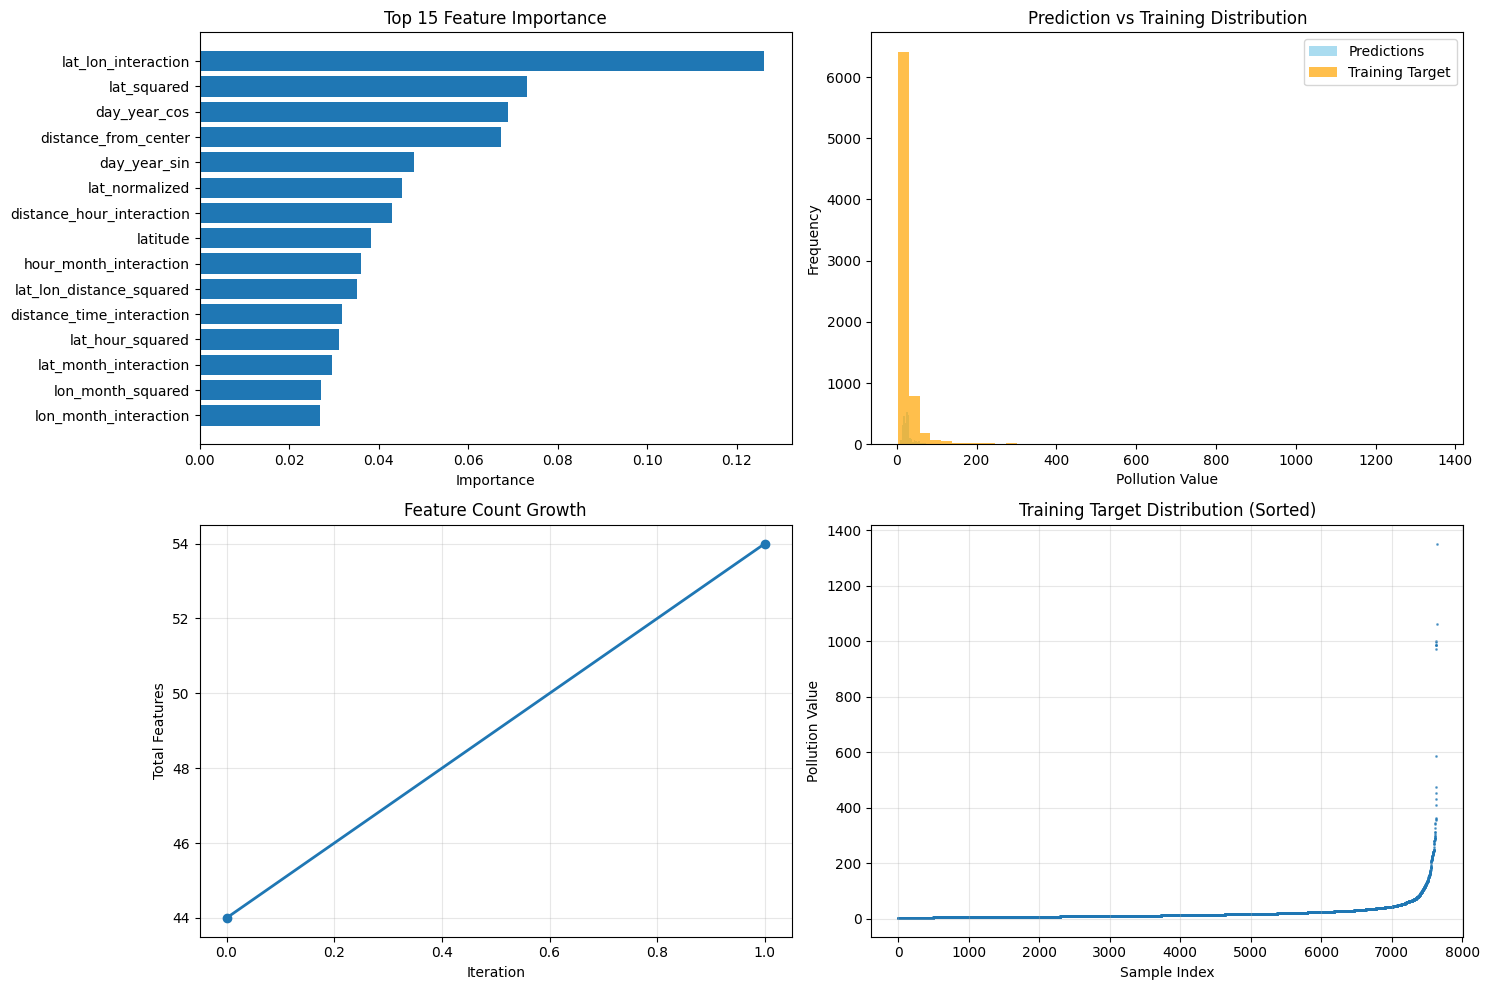

In [ ]:
# Visualize feature importance and results
plt.figure(figsize=(15, 10))

# Feature importance from final model
plt.subplot(2, 2, 1)
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(best_features)
final_model.fit(X_scaled, y)

feature_importance = pd.DataFrame({
    'feature': best_features.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()

# Prediction distribution
plt.subplot(2, 2, 2)
plt.hist(predictions, bins=50, alpha=0.7, label='Predictions', color='skyblue')
plt.hist(y, bins=50, alpha=0.7, label='Training Target', color='orange')
plt.xlabel('Pollution Value')
plt.ylabel('Frequency')
plt.title('Prediction vs Training Distribution')
plt.legend()

# Feature count progression
plt.subplot(2, 2, 3)
feature_counts = [len(X.columns)]  # Start with base features
for i in range(len(best_code) - 1):  # -1 because first is base code
    feature_counts.append(feature_counts[-1] + 5)  # Approximate new features per iteration
feature_counts[-1] = len(best_features.columns)  # Set final count

plt.plot(range(len(feature_counts)), feature_counts, marker='o', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Total Features')
plt.title('Feature Count Growth')
plt.grid(True, alpha=0.3)

# Training target distribution
plt.subplot(2, 2, 4)
plt.scatter(range(len(y)), sorted(y), alpha=0.6, s=1)
plt.xlabel('Sample Index')
plt.ylabel('Pollution Value')
plt.title('Training Target Distribution (Sorted)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./automated_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: automated_feature_analysis.png")

In [ ]:
# Summary report
print("\n" + "="*60)
print("AUTOMATED POLLUTION PREDICTION FEATURE ENGINEERING REPORT")
print("="*60)
print(f"Original feature count: {len(X.columns)}")
print(f"Final feature count: {len(best_features.columns)}")
print(f"Features added: {len(best_features.columns) - len(X.columns)}")
print(f"Best RMSE achieved: {best_score:.4f}")
print(f"Functions generated: {len(best_code)}")
print(f"Submission file: automated_submission.csv")
print(f"Analysis plots: automated_feature_analysis.png")
print("\nNew features created:")
new_features = [col for col in best_features.columns if col not in X.columns]
for feature in new_features:
    print(f"  - {feature}")
print("\n" + "="*60)
print("To use Gemini API for real feature generation:")
print("1. Set up your Gemini API key")
print("2. Install: pip install google-genai")
print("3. Set use_gemini=True in the feature_selection call")
print("="*60)


AUTOMATED POLLUTION PREDICTION FEATURE ENGINEERING REPORT
Original feature count: 44
Final feature count: 54
Features added: 10
Best RMSE achieved: 42.4075
Functions generated: 2
Submission file: automated_submission.csv
Analysis plots: automated_feature_analysis.png

New features created:
  - hour_sin_double
  - hour_cos_double
  - month_sin_quarter
  - week_position
  - lat_lon_distance_squared
  - lat_normalized
  - lon_normalized
  - lat_hour_squared
  - lon_month_squared
  - distance_time_interaction

To use Gemini API for real feature generation:
1. Set up your Gemini API key
2. Install: pip install google-genai
3. Set use_gemini=True in the feature_selection call
